In [ ]:
# !pip3 install torch
# !pip3 install skorch
# !pip3 install xgboost

In [1]:
import os
import json
from pylab import plot, show, savefig, xlim, figure, ylim, legend, boxplot, setp, axes

import sys
stdout = sys.stdout
sys.stdout = stdout

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import utils
from tqdm import tqdm

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import make_scorer, confusion_matrix, fbeta_score

# from training_touchtales.estimator_helper_hc import EstimatorSelectionHelper

# from training_touchtales.models import MODELS, PARAMS

from config_touchtale import TIME_INDEX, TIME_INTERVAL, WINDOW_SIZE, EXP_PARAMS, FS, N_FEATURES, SUBJECT_IDS

from hiclass2 import metrics

from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.feature_selection import RFE
from xgboost import XGBClassifier
from collections import defaultdict

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
MODELS = {
    # 'CNN': NeuralNetClassifier(module=cnn_classifier_original,
    #     module__dropout=DROPOUT,
    #     module__n_labels=LABEL_CLASS_COUNT,
    #     optimizer=OPTIMIZER,
    #     lr=LR,
    #     max_epochs=MAX_EPOCHS,
    #     criterion=CRITERION,
    #     batch_size=BATCH_SIZE,
    #     iterator_train__shuffle=True,
    #     train_split=None,
    #     device=DEVICE,
    #     verbose=0)
    'ExtraTreesClassifier': ExtraTreesClassifier(),
    'RandomForestClassifier': RandomForestClassifier(),
    'AdaBoostClassifier': AdaBoostClassifier(),
    'GradientBoostingClassifier': GradientBoostingClassifier(),
    # 'XGBClassifier': XGBClassifier(),
    # 'SVC': SVC()  # takes a long time to train with linear kernels
}

PARAMS = {

    # 'CNN': {
    # 'local_classifier__batch_size': [128, 256, 512],
    # 'local_classifier__lr': [LR*0.1, LR,  LR*10],
    # 'local_classifier__max_epochs' : [MAX_EPOCHS,  MAX_EPOCHS*2, MAX_EPOCHS*4]
    # }
    'ExtraTreesClassifier': {'n_estimators': [N_FEATURES, 2*N_FEATURES]},
    'RandomForestClassifier': {'n_estimators': [N_FEATURES, 2*N_FEATURES]},
    'AdaBoostClassifier':  {'n_estimators': [N_FEATURES, 2*N_FEATURES]},
    'GradientBoostingClassifier': {'n_estimators': [N_FEATURES, 2*N_FEATURES], 'learning_rate': [0.8, 1.0]},
    # 'XGBClassifier': {'max_depth': (4, 6, 8), 'min_child_weight': (1, 5, 10)},
    # 'SVC': [
    #     {'kernel': ['linear'], 'C': [1, 10]},
    #     {'kernel': ['rbf'], 'C': [1, 10], 'gamma': [0.001, 0.0001]},
    # ],
}


INPUT_PICKLE_FILE = True
INPUT_DIR = 'COMBINED_DATA_TOUCHTALE'
INPUT_PICKLE_NAME = '_featurized_data.pk'
INPUT_LABEL_NAME = '_labels.pk'

INPUT_PICKLE_NAME_VAL = '_val_featurized_data.pk'
INPUT_LABEL_NAME_VAL = '_val_labels.pk'

SAVE_PICKLE_FILE = True
OUTPUT_DIR = 'RESULTS'
OUTPUT_PICKLE_NAME = 'results.pk'
# print("hello")

# LABEL_TYPES = ['pos', 'angle', 'acc', 'cw']
LABEL_TYPES = ['pos', 'angle', 'acc']

"""
Modified from: https://gist.github.com/DimaK415/428bbeb0e79551f780bb990e7c26f813
"""
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline


CV_SPLITS = 3

KEYS_FOR_CM = []
CM = []


class EstimatorSelectionHelper:

    def __init__(self, models, params):
        if not set(models.keys()).issubset(set(params.keys())):
            missing_params = list(set(models.keys()) - set(params.keys()))
            raise ValueError(
                "Some estimators are missing parameters: %s" % missing_params)
        self.models = models
        self.params = params
        self.keys = models.keys()
        self.grid_searches = {}
        self.rfes = {}

        self.keys_for_cm = {}

    def cv(self, n_splits=CV_SPLITS, random_state=0, shuffle=True):
        return StratifiedKFold(n_splits=n_splits, random_state=random_state, shuffle=shuffle)

    def rfe(self, clf, cv=None, step=1, scoring='f1_macro'):
        if cv is None:
            cv = self.cv()
        return RFECV(estimator=clf, step=step, cv=cv, scoring=scoring)

    def pipeline(self, rfecv, gs_cv):
        return Pipeline([('feature_sele', rfecv), ('clf_cv', gs_cv)])

    def fit(self, X, y, cv=None, n_jobs=3, verbose=1, scoring=None, refit=False, pnum='p01', label='pos', window_size='5000ms', val_X=None, val_y=None):
        if cv is None:
            cv = self.cv()

        KEYS_FOR_CM.append(self.keys)

        current_set_cm = []
        for i, key in enumerate(self.keys):
            print("Running GridSearchCV for %s." % key)
            model = self.models[key]
            params = self.params[key]
            rfecv = self.rfe(model)
            gs = GridSearchCV(model, params, cv=cv, n_jobs=n_jobs,
                              verbose=verbose, scoring=scoring, refit=refit,
                              return_train_score=True)
            # print(gs.best_params_)
            # y_pred = gs.best_estimator_.predict(X)
            # print(confusion_matrix(y, y_pred))
            pipe = self.pipeline(rfecv, gs)
            pipe.fit(X, y)


            # print(pipe._final_estimator.best_params_)
            self.y_pred = pipe.predict(val_X)

            cm = confusion_matrix(val_y, self.y_pred)
            # print(f"{key}: ", cm)

            current_set_cm.append(cm)

            self.grid_searches[key] = gs
            self.rfes[key] = rfecv

        CM.append(current_set_cm)



    def score_summary(self, sort_by='mean_score'):
        def row(key, scores, params):
            d = {
                'estimator': key,
                'min_score': min(scores),
                'max_score': max(scores),
                'mean_score': np.mean(scores),
                'std_score': np.std(scores),
            }
            return pd.Series({**params, **d})

        rows = []
        for k in self.grid_searches:
            params = self.grid_searches[k].cv_results_['params']
            scores = []

            keys = self.grid_searches[k].cv_results_.keys()
            # print("keys: ", keys)
            for i in range(self.grid_searches[k].cv.get_n_splits()):
                key = "split{}_test_f1".format(i)
                if key in keys:
                    r = self.grid_searches[k].cv_results_[key]
                    scores.append(r.reshape(len(params), 1))
                else:
                    # print(f"key: {key}, keys: {keys}")
                    pass

            all_scores = np.hstack(scores)
            try:
                print(f"all score {all_scores}, params {params}, type: {type(all_scores)}/{type(params)}")
                
                for p, s in zip(params, all_scores):
                    rows.append((row(k, s, p)))
            except Exception as e:
                print(f"147 all score {all_scores}, params {params}")
                print("error! ", e)

        # print("151", pd.concat(rows, axis=1).T)

        # print(pd.concat(rows, axis=1).T.sort_values(by=['mean_score'], ascending=False))

        df = pd.concat(rows, axis=1).T.sort_values(by=[sort_by], ascending=False)
        # print("152")

        columns = ['estimator', 'min_score',
                   'mean_score', 'max_score', 'std_score']
        columns = columns + [c for c in df.columns if c not in columns]

        # print("158, s", columns)

        return df[columns]

['p_all']


In [2]:
def plot_confusion_matrices(pnum='p01', window_size='5000ms'):
    f, axes = plt.subplots(len(LABEL_TYPES), len(MODELS), figsize=(len(MODELS)*3, len(LABEL_TYPES)*3), sharey='row')
    for i, keyset in enumerate(KEYS_FOR_CM[-len(LABEL_TYPES):]):
        for j, key in enumerate(keyset):
            disp = ConfusionMatrixDisplay(confusion_matrix=CM[-len(LABEL_TYPES)+i][j])
            disp.plot(ax=axes[i][j], xticks_rotation=45)
            disp.ax_.set_title(key.replace('Classifier', ''))
            disp.im_.colorbar.remove()
            disp.ax_.set_xlabel('')
            if j != 0:
                disp.ax_.set_ylabel('')

    f.suptitle(f'Confusion Matrix for {pnum}-{window_size}')
    f.text(0.3, 0, 'Predicted Label (row 1: pos, row 2: angle, row 3: acc)', ha='left')
    # f.text(0.04, 0.5, 'True Label', va='center', rotation='vertical')

    plt.subplots_adjust(wspace=0.8)

    f.colorbar(disp.im_, ax=axes)
    plt.savefig(f'images/cm/cm-{pnum}-{window_size}.png')

UnboundLocalError: local variable 'disp' referenced before assignment

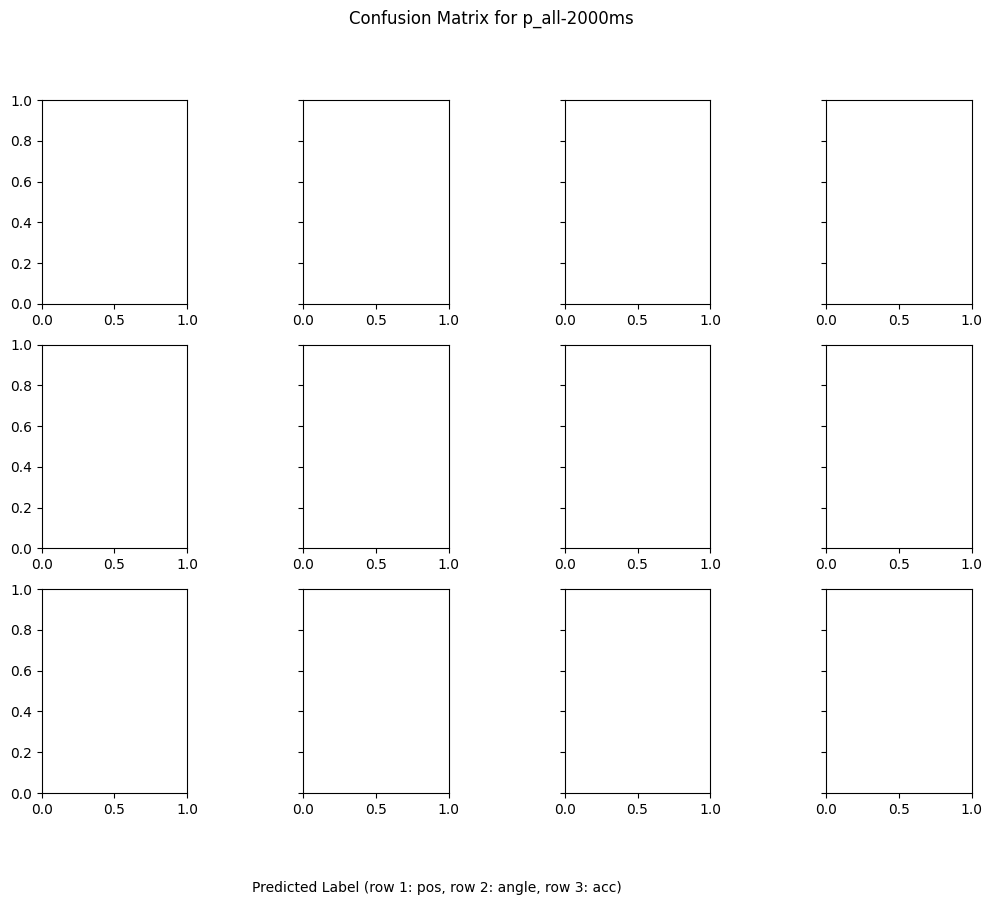

In [3]:
plot_confusion_matrices(pnum='p_all', window_size='2000ms')

  0%|          | 0/1 [00:00<?, ?it/s]

Training participant p_all, 2000
"['timedelta'] not found in axis" no time_delta
train feature dim: (698, 40), train label dim: (698, 5)
train feature dim: (300, 40), train label dim: (300, 5)
Does X have nan?  False 0
Training label type pos
Does y have nan?  False 0
Running GridSearchCV for ExtraTreesClassifier.
Fitting 3 folds for each of 2 candidates, totalling 6 fits
Running GridSearchCV for RandomForestClassifier.
Fitting 3 folds for each of 2 candidates, totalling 6 fits
Running GridSearchCV for AdaBoostClassifier.
Fitting 3 folds for each of 2 candidates, totalling 6 fits
Running GridSearchCV for GradientBoostingClassifier.
Fitting 3 folds for each of 4 candidates, totalling 12 fits
all score [[0.93133047 0.92274678 0.93534483]
 [0.92703863 0.91845494 0.93534483]], params [{'n_estimators': 40}, {'n_estimators': 80}], type: <class 'numpy.ndarray'>/<class 'list'>
all score [[0.93991416 0.91416309 0.93534483]
 [0.93991416 0.91416309 0.93534483]], params [{'n_estimators': 40}, {'n_

/Users/poyuchen/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(


Fitting 3 folds for each of 2 candidates, totalling 6 fits


/Users/poyuchen/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(


Running GridSearchCV for RandomForestClassifier.


/Users/poyuchen/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(


Fitting 3 folds for each of 2 candidates, totalling 6 fits


/Users/poyuchen/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(


Running GridSearchCV for AdaBoostClassifier.


/Users/poyuchen/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(


Fitting 3 folds for each of 2 candidates, totalling 6 fits


/Users/poyuchen/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(


Running GridSearchCV for GradientBoostingClassifier.


/Users/poyuchen/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(


Fitting 3 folds for each of 4 candidates, totalling 12 fits


/Users/poyuchen/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(


all score [[0.93562232 0.9527897  0.96982759]
 [0.93991416 0.9527897  0.96982759]], params [{'n_estimators': 40}, {'n_estimators': 80}], type: <class 'numpy.ndarray'>/<class 'list'>
all score [[0.93562232 0.95708155 0.96551724]
 [0.93562232 0.95708155 0.96551724]], params [{'n_estimators': 40}, {'n_estimators': 80}], type: <class 'numpy.ndarray'>/<class 'list'>
all score [[0.73819742 0.70815451 0.80172414]
 [0.73819742 0.70815451 0.80172414]], params [{'n_estimators': 40}, {'n_estimators': 80}], type: <class 'numpy.ndarray'>/<class 'list'>
all score [[0.96566524 0.92274678 0.93965517]
 [0.96995708 0.92703863 0.94396552]
 [0.94420601 0.93133047 0.90517241]
 [0.95708155 0.93562232 0.90517241]], params [{'learning_rate': 0.8, 'n_estimators': 40}, {'learning_rate': 0.8, 'n_estimators': 80}, {'learning_rate': 1.0, 'n_estimators': 40}, {'learning_rate': 1.0, 'n_estimators': 80}], type: <class 'numpy.ndarray'>/<class 'list'>


100%|██████████| 1/1 [09:58<00:00, 598.52s/it]


results {'pnum': 'p_all', 'y_hc_pos': array(['pride', 'love', 'sadness', 'love', 'love', 'love', 'stress',
       'love', 'pride', 'love', 'pride', 'love', 'sadness', 'love',
       'anger', 'love', 'surprise', 'gratitude', 'gratitude', 'love',
       'love', 'love', 'love', 'love', 'pride', 'love', 'love', 'love',
       'love', 'love', 'love', 'fear', 'anger', 'love', 'love', 'pride',
       'love', 'love', 'love', 'love', 'envy', 'love', 'love', 'love',
       'love', 'gratitude', 'pride', 'pride', 'love', 'anxiety', 'pride',
       'love', 'anger', 'pride', 'love', 'love', 'love', 'pride', 'envy',
       'love', 'love', 'love', 'pride', 'anger', 'pride', 'love',
       'gratitude', 'love', 'pride', 'love', 'love', 'love', 'love',
       'love', 'love', 'sympathy', 'sadness', 'sadness', 'love', 'pride',
       'pride', 'love', 'love', 'love', 'love', 'longing', 'love', 'love',
       'love', 'love', 'love', 'love', 'love', 'gratitude', 'love',
       'love', 'pride', 'love', 'love',

  0%|          | 0/1 [00:00<?, ?it/s]

Training participant p_all, 5000
"['timedelta'] not found in axis" no time_delta
train feature dim: (311, 40), train label dim: (311, 5)
train feature dim: (134, 40), train label dim: (134, 5)
Does X have nan?  False 0
Training label type pos
Does y have nan?  False 0
Running GridSearchCV for ExtraTreesClassifier.
Fitting 3 folds for each of 2 candidates, totalling 6 fits
Running GridSearchCV for RandomForestClassifier.
Fitting 3 folds for each of 2 candidates, totalling 6 fits
Running GridSearchCV for AdaBoostClassifier.
Fitting 3 folds for each of 2 candidates, totalling 6 fits
Running GridSearchCV for GradientBoostingClassifier.
Fitting 3 folds for each of 4 candidates, totalling 12 fits
all score [[0.94230769 0.95192308 0.95145631]
 [0.94230769 0.95192308 0.93203883]], params [{'n_estimators': 40}, {'n_estimators': 80}], type: <class 'numpy.ndarray'>/<class 'list'>
all score [[0.93269231 0.95192308 0.91262136]
 [0.94230769 0.95192308 0.93203883]], params [{'n_estimators': 40}, {'n_

/Users/poyuchen/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


Fitting 3 folds for each of 2 candidates, totalling 6 fits
Running GridSearchCV for RandomForestClassifier.


/Users/poyuchen/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(
/Users/poyuchen/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


Fitting 3 folds for each of 2 candidates, totalling 6 fits


/Users/poyuchen/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


Running GridSearchCV for AdaBoostClassifier.


/Users/poyuchen/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


Fitting 3 folds for each of 2 candidates, totalling 6 fits
Running GridSearchCV for GradientBoostingClassifier.


/Users/poyuchen/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(
/Users/poyuchen/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


Fitting 3 folds for each of 4 candidates, totalling 12 fits


/Users/poyuchen/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


all score [[0.94230769 0.98076923 0.95145631]
 [0.94230769 0.97115385 0.95145631]], params [{'n_estimators': 40}, {'n_estimators': 80}], type: <class 'numpy.ndarray'>/<class 'list'>
all score [[0.91346154 0.94230769 0.94174757]
 [0.92307692 0.94230769 0.95145631]], params [{'n_estimators': 40}, {'n_estimators': 80}], type: <class 'numpy.ndarray'>/<class 'list'>
all score [[0.65384615 0.86538462 0.82524272]
 [0.65384615 0.86538462 0.82524272]], params [{'n_estimators': 40}, {'n_estimators': 80}], type: <class 'numpy.ndarray'>/<class 'list'>
all score [[0.93269231 0.94230769 0.93203883]
 [0.93269231 0.94230769 0.9223301 ]
 [0.92307692 0.91346154 0.9223301 ]
 [0.92307692 0.91346154 0.9223301 ]], params [{'learning_rate': 0.8, 'n_estimators': 40}, {'learning_rate': 0.8, 'n_estimators': 80}, {'learning_rate': 1.0, 'n_estimators': 40}, {'learning_rate': 1.0, 'n_estimators': 80}], type: <class 'numpy.ndarray'>/<class 'list'>


100%|██████████| 1/1 [06:37<00:00, 397.32s/it]

results {'pnum': 'p_all', 'y_hc_pos': array(['love', 'surprise', 'love', 'love', 'love', 'love', 'love',
       'pride', 'love', 'pride', 'love', 'love', 'love', 'love', 'pride',
       'envy', 'love', 'pride', 'love', 'love', 'love', 'love', 'love',
       'love', 'love', 'love', 'love', 'love', 'love', 'anger', 'love',
       'pride', 'love', 'envy', 'fear', 'gratitude', 'love', 'envy',
       'love', 'love', 'pride', 'guilt', 'longing', 'love', 'pride',
       'love', 'sadness', 'love', 'love', 'love', 'love', 'gratitude',
       'love', 'love', 'love', 'love', 'love', 'love', 'love', 'love',
       'love', 'love', 'love', 'pride', 'gratitude', 'pride', 'love',
       'love', 'love', 'love', 'love', 'pride', 'love', 'love', 'love',
       'love', 'love', 'love', 'love', 'love', 'guilt', 'gratitude',
       'love', 'envy', 'love', 'love', 'love', 'gratitude', 'love',
       'love', 'love', 'love', 'pride', 'love', 'envy', 'love', 'love',
       'pride', 'love', 'love', 'love', 'love'

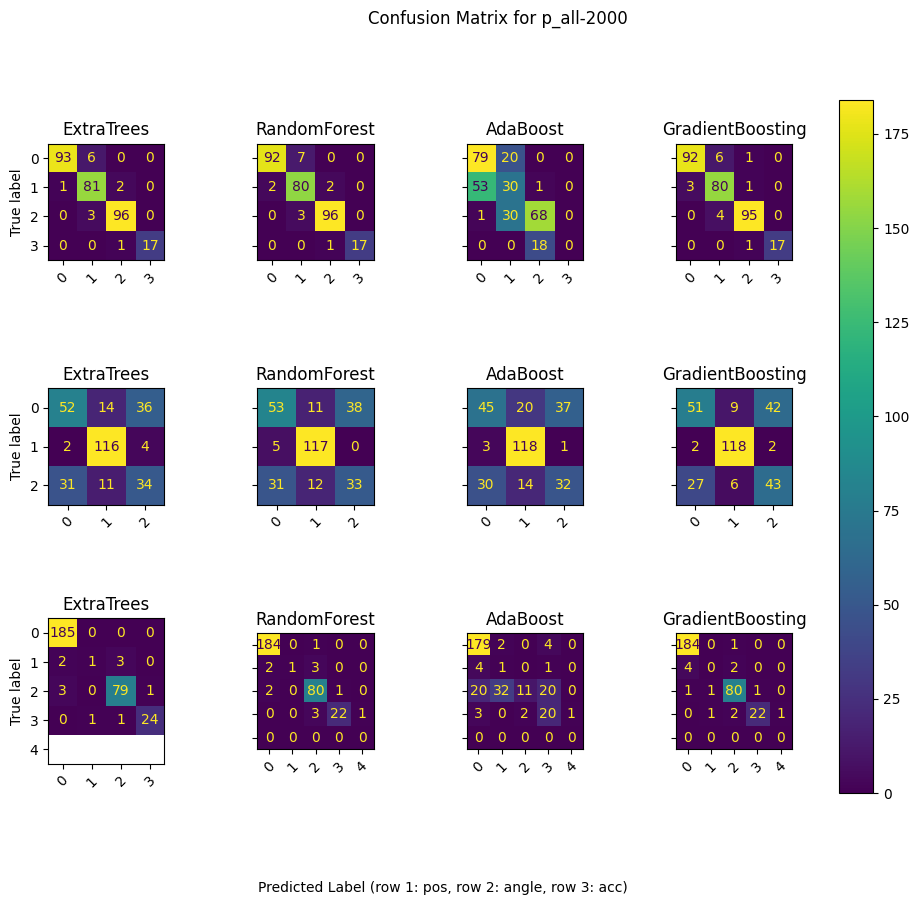

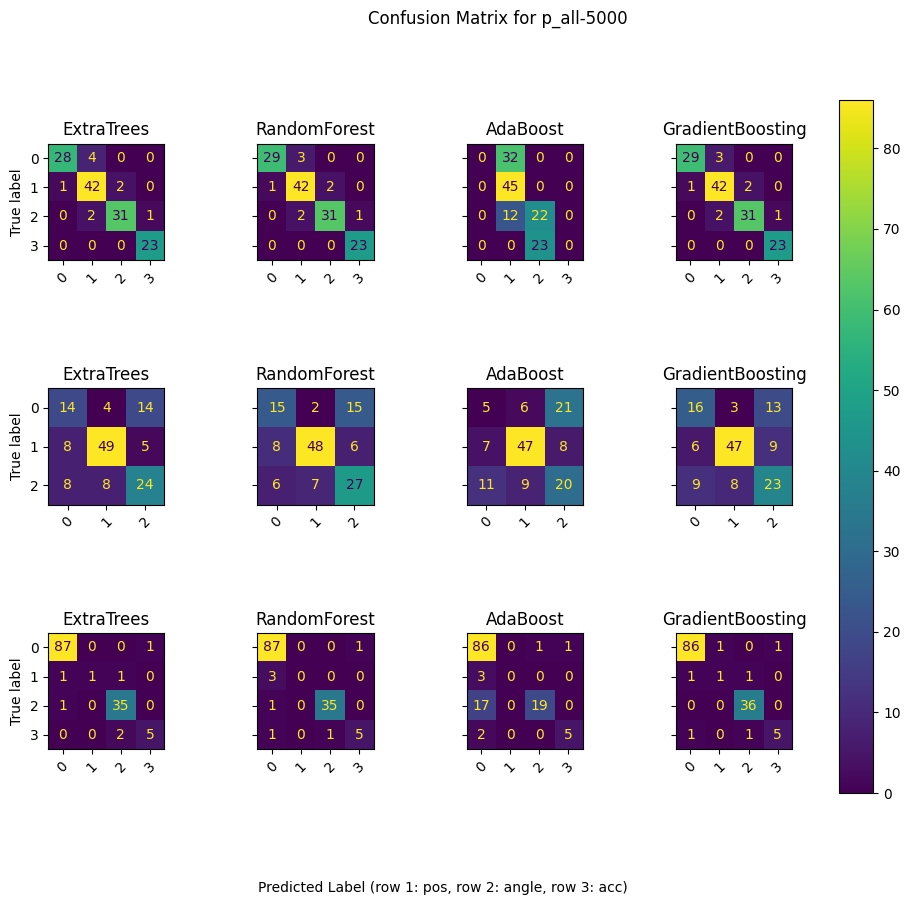

In [4]:
TYPE_TO_TRAIN = 'cw_mode'

def fit_helper(X, y, pnum='p01', label='pos', window_size='5000ms', val_X=None, val_y=None, models=MODELS, params=PARAMS, n_jobs=-1, 
               scoring={ "f1": make_scorer(metrics.f1), "prec" : make_scorer(metrics.precision), "recall": make_scorer(metrics.recall)}, cw_classes=None):

    # "confusionMat": make_scorer(metrics.confusion_matrix) make_scorer(fbeta_score, beta=2)
    # print(models, params, cw_classes)
    helper = EstimatorSelectionHelper(models, params)
    unique, counts = np.unique(y, return_counts=True)
    if len(unique) < 2:
        print(y)
        print("Not enough label classes! ")
        return -1, -1 
    helper.fit(X, y, scoring=scoring, n_jobs=n_jobs, refit='f1', pnum=pnum, label=label, window_size=window_size, val_X=val_X, val_y=val_y)
    try:
        scores = helper.score_summary()
        return helper, scores
    except ValueError as e:
        print("Value error! ", e)
        return -1, -1 


def train(feature_dict, label_dict, label_types=LABEL_TYPES, pnum='p01', window_size='5000ms', val_feature_dict=None, val_label_dict=None):

    # read the features back into a numpy array
    # bands = feature_dict[feature_types].to_numpy()
    # features = np.empty((bands.shape[0], bands.shape[1], 64, 64))
    # for band in range(len(feature_types)):
    #     band_arr = bands[:,band]
    #     for window in range(band_arr.shape[0]):
    #         band_im = np.array(band_arr[window])
    #         features[window, band, :, :] = band_im

    # print(feature_dict)
    # print(val_feature_dict)
    try:
        features = feature_dict.drop('timedelta', axis=1).to_numpy()
        val_features = val_feature_dict.drop('timedelta', axis=1).to_numpy()
        # print(val_feature_dict)
        
    except Exception as e:
        features = feature_dict.to_numpy()
        val_features = val_feature_dict.to_numpy()
        print(e, 'no time_delta')

    X = features.astype(np.float32)
    val_X = val_features.astype(np.float32)

    print(f"train feature dim: {feature_dict.shape}, train label dim: {label_dict.shape}")
    print(f"train feature dim: {val_feature_dict.shape}, train label dim: {val_label_dict.shape}")

    # print(X.shape)

    res = {}
   
    res['pnum'] = pnum

    # Y = label_dict.loc[label_dict['window_id'].isin(feature_dict['window_id'].unique())]
    
    Y = label_dict
    val_Y = val_label_dict
    # return

    LE = LabelEncoder() # transform string to class values
    LE.fit(Y[TYPE_TO_TRAIN])

    y_cw_str = Y[TYPE_TO_TRAIN]
    y_cw = LE.transform(y_cw_str)

    print("Does X have nan? ", np.isnan(X).any(), np.count_nonzero(np.isnan(X)))

    LE_val = LabelEncoder() # transform string to class values
    LE_val.fit(val_Y[TYPE_TO_TRAIN])

    val_y_cw_str = val_Y[TYPE_TO_TRAIN]
    val_y_cw = LE.transform(val_y_cw_str)

    if np.isnan(X).any():
        mask = np.isnan(X)
        idx = np.where(~mask,np.arange(mask.shape[1]),0)
        np.maximum.accumulate(idx, axis=1, out=idx)
        X_filtered = X[np.arange(idx.shape[0])[:, None], idx]
    else:
        X_filtered = X

    for label_type in label_types: # train every label type
        print(f'Training label type {label_type}')

        # y = np.array(list(zip(y_cw, Y[label_type])))
        # y_str = np.array(list(zip(y_cw_str, Y[label_type] )))

        # y = np.array(y_cw)
        y_str = np.array(y_cw_str)
        val_y_str = np.array(val_y_cw_str)

        # print(y_cw)
        # print("shapeee", X.shape, Y[label_type].shape)
        # return

        y = LE.fit_transform(Y[label_type])
        val_y = LE.fit_transform(val_Y[label_type])

        res['y_hc_' + label_type] = y_str

        print("Does y have nan? ", np.isnan(y).any(), np.count_nonzero(np.isnan(y)))
        if np.isnan(y).any():
            mask = np.isnan(y)
            idx = np.where(~mask,np.arange(mask.shape[1]),0)
            np.maximum.accumulate(idx, axis=1, out=idx)
            y_filtered = y[np.arange(idx.shape[0])[:, None], idx]
        else:
            y_filtered = y

        # print(sorted(y_filtered), np.array(y_filtered).shape)

        helper, scores = fit_helper(X_filtered, y_filtered, pnum=pnum, label=label_type, window_size=window_size, val_X=val_X, val_y=val_y)
        res['scores_hc_' + label_type] = scores
        del helper
        del scores
    
    plot_confusion_matrices(pnum=pnum, window_size=window_size)

    return res

for i in range(0, 1):
    for window_size in EXP_PARAMS['WINDOW_SIZE']:
        if INPUT_PICKLE_FILE:
            participant_results = {}
            for subject_id in tqdm(SUBJECT_IDS):
                # utils.logger.info(f'Training participant {subject_id}')

                print(f'Training participant {subject_id}, {window_size}')

                training_data_filename = subject_id + "_" + str(window_size) + 'ms' + INPUT_PICKLE_NAME
                input_pickle_file_path = os.path.join(INPUT_DIR, training_data_filename)
                input_label_file_path = os.path.join(INPUT_DIR, str(window_size) + 'ms' + INPUT_LABEL_NAME)

                features = utils.load_pickle(pickled_file_path=input_pickle_file_path)
                labels = utils.load_pickle(pickled_file_path=input_label_file_path)

                val_data_filename = subject_id + "_" + str(window_size) + 'ms' + INPUT_PICKLE_NAME_VAL
                input_val_pickle_file_path = os.path.join(INPUT_DIR, val_data_filename)
                input_val_label_file_path = os.path.join(INPUT_DIR, str(window_size) + 'ms' + INPUT_LABEL_NAME_VAL)

                val_features = utils.load_pickle(pickled_file_path=input_val_pickle_file_path)
                val_labels = utils.load_pickle(pickled_file_path=input_val_label_file_path)

                utils.logger.info(f'Window size {window_size} - Iteration {i}')
                training_results = train(features[subject_id], labels[subject_id], pnum=subject_id, window_size=window_size, val_feature_dict=val_features[subject_id], val_label_dict=val_labels[subject_id])
                
                print("results", training_results)
                if SAVE_PICKLE_FILE:
                    iter_ = subject_id + "_" + str(i) + '_' + str(window_size) + 'ms_hc_cw_' + OUTPUT_PICKLE_NAME
                    os.makedirs(OUTPUT_DIR, exist_ok=True)
                    output_pickle_file_path = os.path.join(OUTPUT_DIR, iter_)
                    utils.pickle_data(data=training_results, file_path=output_pickle_file_path)

In [ ]:
INPUT_DIR = '/Users/poyuchen/Desktop/UBC/Engineering-Physics/Fifth-Year/Summer/SPIN/emod-eegify.nosync/src/RESULTS/'
INPUT_PICKLE_NAME = 'results.pk'

cols_to_print = ['estimator', 'mean_score', 'std_score']

labels_to_plot = ['scores_hc_pos', 'scores_hc_angle', 'scores_hc_acc']
labels_to_print = [label.split('_')[-1] for label in labels_to_plot]
# labels_to_plot = ['scores_hc_acc']
score_to_plot = 'mean_score'
# cols_to_print = ['estimator', 'min_score', 'mean_score', 'max_score', 'std_score']

def setBoxColors(bp):
    # print(bp)
    setp(bp['boxes'][0], color='blue')
    setp(bp['caps'][0], color='blue')
    setp(bp['caps'][1], color='blue')
    setp(bp['whiskers'][0], color='blue')
    setp(bp['whiskers'][1], color='blue')
    setp(bp['fliers'][0], markeredgecolor='grey')
    setp(bp['medians'][0], color='black')

    setp(bp['boxes'][1], color='red')
    setp(bp['caps'][2], color='red')
    setp(bp['caps'][3], color='red')
    setp(bp['whiskers'][2], color='red')
    setp(bp['whiskers'][3], color='red')
    setp(bp['fliers'][1], markeredgecolor='grey')
    setp(bp['medians'][1], color='black')

    setp(bp['boxes'][2], color='green')
    setp(bp['caps'][3], color='green')
    setp(bp['caps'][4], color='green')
    setp(bp['whiskers'][3], color='green')
    setp(bp['whiskers'][4], color='green')
    setp(bp['fliers'][2], markeredgecolor='grey')
    setp(bp['medians'][2], color='black')

# # set axes limits and labels
# xlim(0,9)
# ylim(0,9)
# ax.set_xticklabels(['A', 'B', 'C'])
# ax.set_xticks([1.5, 4.5, 7.5])

# # draw temporary red and blue lines and use them to create a legend
# hB, = plot([1,1],'b-')
# hR, = plot([1,1],'r-')
# legend((hB, hR),('Apples', 'Oranges'))
# hB.set_visible(False)
# hR.set_visible(False)

# savefig('boxcompare.png')
# show()

YMAX = 1
YMIN = 0.2
XMIN = -2

for i, window_size in enumerate(EXP_PARAMS["WINDOW_SIZE"]):
    data_to_plot = {}

    fig = figure(figsize=(8, 6))
    ax = axes()

    count = 0
    midpoints = []
    for i, subject_id in enumerate(SUBJECT_IDS):
        input_pickle_file_path = os.path.join(INPUT_DIR, subject_id + "_" + str(0) + '_' + str(window_size) + 'ms_hc_cw_' + INPUT_PICKLE_NAME)
        res = utils.load_pickle(pickled_file_path=input_pickle_file_path)

        data_to_plot[res['pnum']] = []
        for label in labels_to_plot:
            data_to_plot[res['pnum']].append(res[label][score_to_plot].to_list())


        # print(np.array(data_to_plot[res['pnum']]).shape)
        bp = boxplot(np.array(data_to_plot[res['pnum']]).transpose(), positions=np.arange(count, count+3), widths = 0.8)
        setBoxColors(bp)

        midpoints.append(count+1)

        if i != len(SUBJECT_IDS)-1:
            ax.vlines(x=count+3.5, ymin=YMIN, ymax=YMAX, colors='orange', ls='--', lw=1, alpha=0.5)
        count += 5

    ax.set_title(f"Cross Validation Mean Score {'-'.join(labels_to_print)}\n for Window Size {window_size}ms")
    ax.set_xlabel(f"Participant ID")
    ax.set_ylabel(f"{score_to_plot}")
    
    ylim(YMIN, YMAX)
    xlim(XMIN, count)

    # print(midpoints, SUBJECT_IDS)

    hB, = plot([1,1],'b-')
    hR, = plot([1,1],'r-')
    hG, = plot([1,1],'g-')
    legend((hB, hR, hG), ('position', 'angle', 'accumulator'))
    hB.set_visible(False)
    hR.set_visible(False)
    hG.set_visible(False)

    ax.xaxis.set_ticks(midpoints, sorted(SUBJECT_IDS))
    ax.set_xticks(midpoints)
    show()


# Examples

In [ ]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.datasets import make_classification
X, y = make_classification(n_features=4, random_state=0)
print(X.shape, y.shape)
clf = ExtraTreesClassifier(n_estimators=100, random_state=0)
clf.fit(X, y)
clf.predict([[0, 0, 0, 0]])